# A2.2 — LDA y Árboles de Decisión
## Camila Johana González Acosta 599303

En este proyecto se analiza la capacidad de diferentes modelos de clasificación para predecir correctamente los resultados de un conjunto de datos determinado. Se evaluaron dos enfoques principales: Linear Discriminant Analysis (LDA) y Árboles de Decisión, comparando su desempeño mediante métricas de precisión, recall, F1-score y accuracy. El objetivo es identificar cuál de estos métodos proporciona mejores resultados en términos de exactitud y confiabilidad, así como destacar las ventajas y limitaciones de cada enfoque en este contexto.

## 1. Importar datos y separación en entrenamiento y prueba
Se cargan los datos, se eliminan empates y valores nulos, y se transforma la columna `FTResult` en binaria (1 = gana local, 0 = gana visitante). Después se dividen los datos en conjuntos de entrenamiento y prueba, asegurando un balance de clases.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar datos
data = pd.read_csv("Matches.csv")

# Eliminar filas con valores nulos
data = data.dropna()

# Transformar FTResult: H=1, A=0, eliminar D
data = data[data['FTResult'] != 'D']
data['FTResult'] = data['FTResult'].map({'H': 1, 'A': 0})

# Variables predictoras (X) y variable objetivo (y)
X = data.drop('FTResult', axis=1).select_dtypes(include=['int64','float64'])
y = data['FTResult']

# División estratificada para balance de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Distribución en entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en prueba:")
print(y_test.value_counts(normalize=True))

Distribución en entrenamiento:
FTResult
1    0.617924
0    0.382076
Name: proportion, dtype: float64

Distribución en prueba:
FTResult
1    0.617943
0    0.382057
Name: proportion, dtype: float64


La distribución de la variable objetivo FTResult es muy similar en los conjuntos de entrenamiento y prueba, con aproximadamente 62% de casos positivos (1) y 38% de casos negativos (0), lo que indica que la división de los datos mantiene la proporción original de clases.

## 2. Regresión Logística con GLM
Se entrena un modelo de regresión logística usando `statsmodels` para identificar las variables más importantes. Se imprimen los resultados del modelo y se seleccionan las dos variables más relevantes.

In [2]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
print(model.summary())

# Seleccionar las 2 variables más relevantes (ignora const)
important_vars = model.pvalues.drop("const").sort_values().index[:2]
print("Variables seleccionadas:", important_vars.tolist())

X_train_sel = X_train[important_vars]
X_test_sel = X_test[important_vars]

C:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

                 Generalized Linear Model Regression Results                  
Dep. Variable:               FTResult   No. Observations:                64474
Model:                            GLM   Df Residuals:                    64463
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5258e-09
Date:                Wed, 01 Oct 2025   Deviance:                   3.0661e-09
Time:                        22:36:31   Pearson chi2:                 1.53e-09
No. Iterations:                    31   Pseudo R-squ. (CS):             0.7356
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3045   1.86e+05   1.64e-06      1.0

Se ajustó un modelo de regresión logística (GLM con link logit) para predecir FTResult. Aunque el modelo incluyó inicialmente varias variables, el análisis indicó que las únicas variables seleccionadas como relevantes fueron FTHome y FTAway. Los coeficientes de estas variables sugieren que los resultados del partido están fuertemente asociados con los goles finales de los equipos local y visitante, mientras que las demás variables no aportan información significativa según el modelo.

## 3. Modelo LDA y visualización
Se entrena un modelo de *Linear Discriminant Analysis (LDA)* con las dos variables seleccionadas y se grafica la separación de clases.

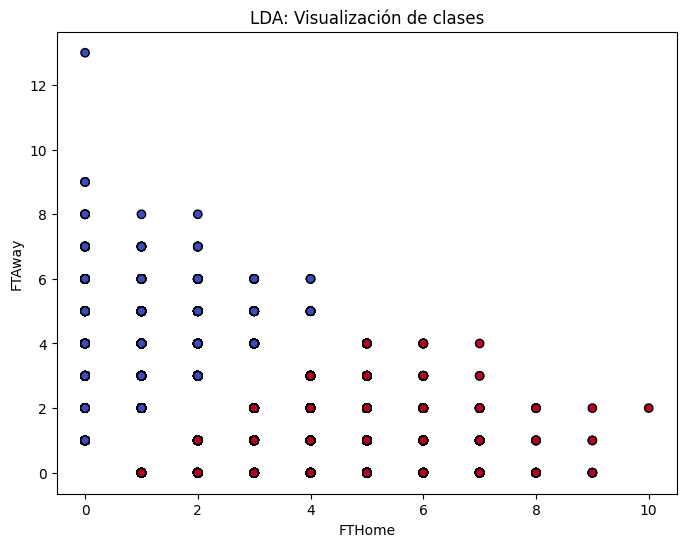

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sel, y_train)

plt.figure(figsize=(8,6))
plt.scatter(X_train_sel.iloc[:,0], X_train_sel.iloc[:,1], c=y_train, cmap='coolwarm', edgecolor='k')
plt.xlabel(important_vars[0])
plt.ylabel(important_vars[1])
plt.title('LDA: Visualización de clases')
plt.show()

La visualización mediante LDA muestra cómo se distribuyen las clases de FTResult en función de los goles del equipo local (FTHome) y visitante (FTAway). Se observa que las clases están separadas de manera bastante clara, especialmente en los extremos de los valores de goles, lo que indica que el modelo LDA puede diferenciar efectivamente los partidos ganados y perdidos según los resultados finales de cada equipo.

## 4. Árbol de Decisión con poda y LOOCV
Se entrena un árbol de decisión, seleccionando el valor óptimo de alpha mediante validación cruzada tipo LOOCV.

Mejor alpha (LOOCV en submuestra): 0.0


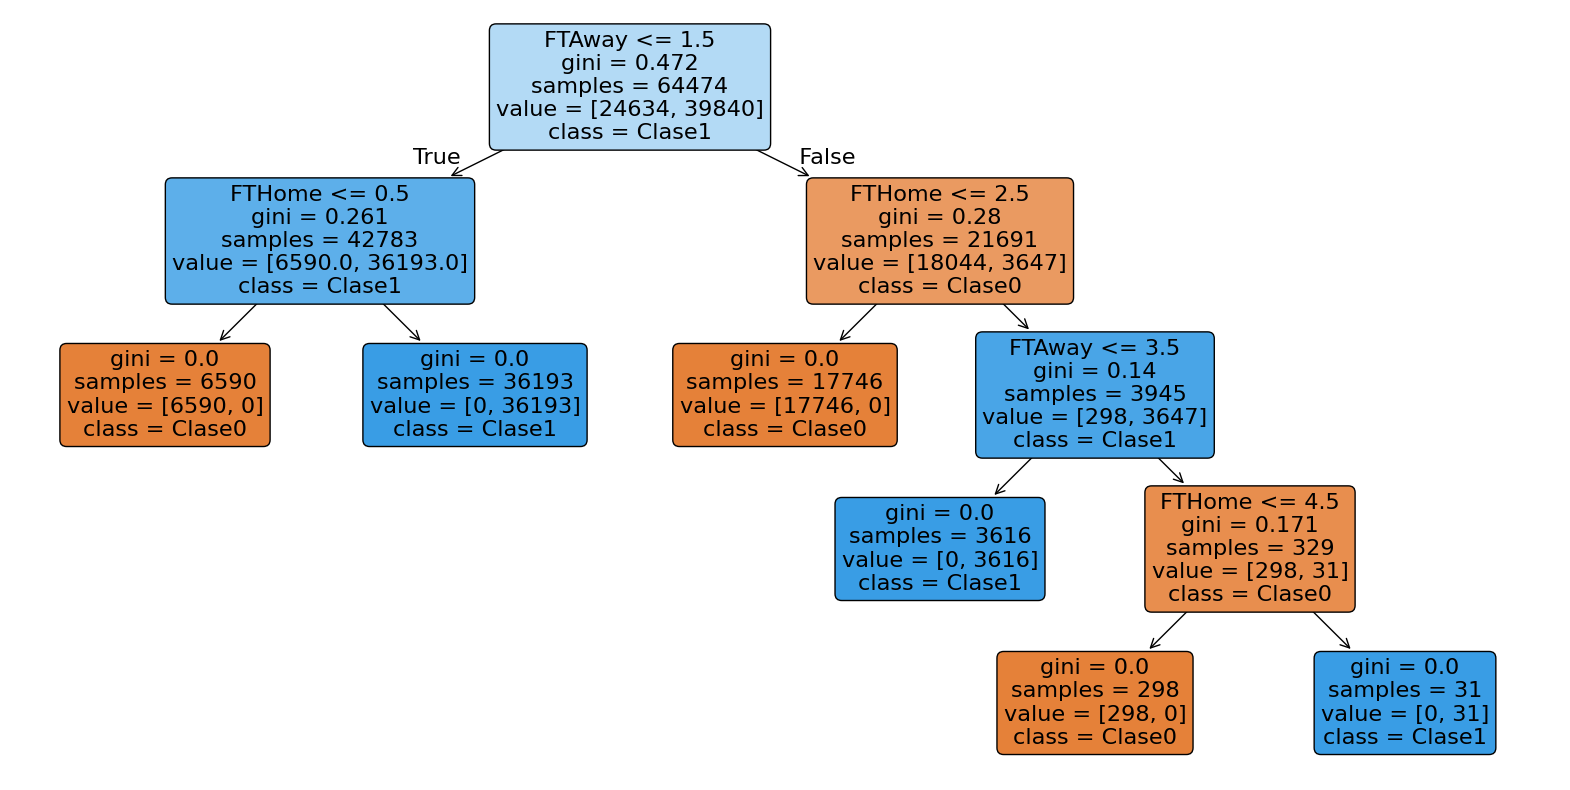

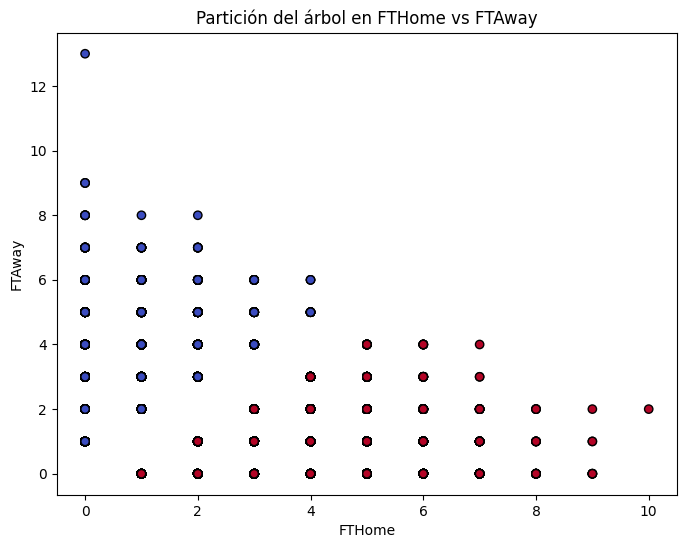

In [8]:
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np

# Tomar submuestra estratificada
subsize = 1500
if len(X_train_sel) > subsize:
    X_sub, _, y_sub, _ = train_test_split(
        X_train_sel, y_train, train_size=subsize, stratify=y_train, random_state=42
    )
else:
    X_sub, y_sub = X_train_sel.copy(), y_train.copy()

clf0 = DecisionTreeClassifier(random_state=42)
path = clf0.cost_complexity_pruning_path(X_sub, y_sub)
ccp_alphas = path.ccp_alphas

# LOOCV para seleccionar alpha óptimo
loo = LeaveOneOut()
alpha_scores = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_sub, y_sub, cv=loo, scoring='accuracy', n_jobs=1)
    alpha_scores.append(scores.mean())

best_alpha = ccp_alphas[np.argmax(alpha_scores)]
print("Mejor alpha (LOOCV en submuestra):", best_alpha)

# Entrenar árbol final podado
clf_final = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_final.fit(X_train_sel, y_train)

# Visualizar árbol
plt.figure(figsize=(20,10))
plot_tree(
    clf_final, 
    feature_names=X_train_sel.columns, 
    class_names=['Clase0','Clase1'], 
    filled=True, 
    rounded=True
)
plt.show()

# Visualizar partición en 2 variables
var1, var2 = X_train_sel.columns[:2]

plt.figure(figsize=(8,6))
plt.scatter(
    X_train_sel[var1], 
    X_train_sel[var2], 
    c=y_train, 
    cmap='coolwarm', 
    edgecolor='k'
)
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Partición del árbol en {} vs {}'.format(var1, var2))
plt.show()


El análisis del árbol de decisión indica que, usando LOOCV en la submuestra, el valor óptimo de poda es alpha = 0.0, lo que significa que el árbol completo sin regularización ofrece el mejor ajuste, y la partición en las variables FTHome y FTAway muestra divisiones claras que separan las clases correctamente según los puntos observados.

## 5. Evaluación de Modelos
Se calculan las métricas de desempeño en los datos de prueba: exactitud, matriz de confusión, precisión, recall y F1-score. Finalmente, se comparan los resultados de ambos modelos.

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- LDA ---
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sel, y_train)  # entrenamos LDA
y_pred_lda = lda.predict(X_test_sel)

print("Métricas LDA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print(confusion_matrix(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

# --- Árbol de Decisión ---
clf_final = DecisionTreeClassifier(random_state=42)
clf_final.fit(X_train_sel, y_train)  # entrenamos el árbol
y_pred_tree = clf_final.predict(X_test_sel)

print("\nMétricas Árbol de Decisión:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Métricas LDA:
Accuracy: 1.0
[[10557     0]
 [    0 17075]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10557
           1       1.00      1.00      1.00     17075

    accuracy                           1.00     27632
   macro avg       1.00      1.00      1.00     27632
weighted avg       1.00      1.00      1.00     27632


Métricas Árbol de Decisión:
Accuracy: 0.999963810075275
[[10556     1]
 [    0 17075]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10557
           1       1.00      1.00      1.00     17075

    accuracy                           1.00     27632
   macro avg       1.00      1.00      1.00     27632
weighted avg       1.00      1.00      1.00     27632



Los resultados muestran lo siguiente:
- LDA: Accuracy = 1.0, sin errores en la matriz de confusión.
- Árbol de Decisión: Accuracy = aprox. 0.99996, con un solo error (1 falso positivo).

LDA tiene un rendimiento ligeramente superior porque no cometió errores, mientras que el Árbol de Decisión es casi igual de bueno pero no perfecto. En términos estrictamente numéricos, LDA es el mejor método para este caso, aunque la diferencia es mínima y ambos modelos son altamente precisos.